<h3>Installing Required Libraries</h3>

In [3]:
# !pip install tensorflow
# !pip install numpy
# !pip install tensorflow.keras
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 39.0 MB/s eta 0:00:00


<h3>Mounting Google Drive</h3>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<h3>Importing</h3>

In [38]:
import cv2
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

<h3>Loading CIFAR-10 Dataset from Keras.</h3>

<br>

<h5><b><i>It has followig Classes:</i></b><br><h5>
Class 0: Airplane<br>
Class 1: Automobile<br>
Class 2: Bird<br>
Class 3: Cat<br>
Class 4: Deer<br>
Class 5: Dog<br>
Class 6: Frog<br>
Class 7: Horse<br>
Class 8: Ship<br>
Class 9: Truck<br>


In [39]:
className = {"0":'Airplane','1':'Automobile','2':'Bird','3':'Cat','4':'Deer','5':'Dog',
             '6':'Frog','7':'Horse','8':'Ship','9':'Truck'}

num_classes = 10  # Number of classes in the dataset (hyperparameters)
input_shape = (32, 32, 3) # Input shape of the images (hyperparameter)


# Load the CIFAR-10 dataset which includes above 4 Classes
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print('\n\n')

# Display shapes of train and test datasets
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")




x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


<h3>Image Data Augmentation</h3>
<i>Image data augmentation is a technique that creates new images from existing ones. To do that, you make some small changes to them, such as adjusting the brightness of the image, or rotating the image, or shifting the subject in the image horizontally or vertically.</i>

In [40]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.02),
        layers.RandomWidth(0.2),
        layers.RandomHeight(0.2),
    ]
)

# Setting the state of the normalization layer.
data_augmentation.layers[0].adapt(x_train)

<h3>Encoder</h3>

<i>The encoder model takes the image as input and turns it into a 2048-dimensional feature vector.</i>

In [69]:
def create_encoder():
    resnet = keras.applications.ResNet50V2(
        include_top=False, weights=None, input_shape=input_shape, pooling="avg"
    )

    inputs = keras.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    outputs = resnet(augmented)
    model = keras.Model(inputs=inputs, outputs=outputs, name="cifar10-encoder")
    return model


encoder = create_encoder()
encoder.summary()


learning_rate = 0.001 # Learning Rate (Hyper-parameters)


batch_size = 265  # Size of each batch for training (Hyper-parameters)
hidden_units = 512
projection_units = 128


num_epochs = 50 # Number of Training Epochs
dropout_rate = 0.5
temperature = 0.05

Model: "cifar10-encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 sequential_2 (Sequential)   (None, None, None, 3)     7         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
Total params: 23,564,807
Trainable params: 23,519,360
Non-trainable params: 45,447
_________________________________________________________________


<h3>Building the Classification Model</h3>
<ul>
  <li>
    <i>
    The classification model adds a fully-connected layer on top of the encoder, plus a softmax layer with the target classes.
    </i>
    <br>
  <li>
    <i>
    The Classifier uses Convolution Neural Networks to classify the images, with the help of CNN we can cluster the similar images together more efficiently
    </i>
</ul>

In [70]:
def create_classifier(encoder, trainable=True):

    for layer in encoder.layers:
        layer.trainable = trainable

    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    features = layers.Dropout(dropout_rate)(features)
    features = layers.Dense(hidden_units, activation="relu")(features)
    features = layers.Dropout(dropout_rate)(features)
    outputs = layers.Dense(num_classes, activation="softmax")(features)

    model = keras.Model(inputs=inputs, outputs=outputs, name="cifar10-classifier")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )
    return model

<b>There are 2 ways in which we can train the Supervised Contrastive Classifier</b><br>

<ol>
  <li>Train the Encoder and Classifier together
  <li>
    <ul>
      <li> Train the Encoder
      <li> With the Pretained Encoder, Train the Classifier
    </ul>
</ol>


We will do both and compare the classifier build by both model

<i><b><h3> Train the Encoder and Classifier together </h3></b></i>


In [71]:
# Creating Encoder Instance
encoder = create_encoder()

# Creating instance of Classifier using the Encoder
classifier = create_classifier(encoder)

# Printing Classifier Summary
classifier.summary()

# Training the Classifier
history = classifier.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs)

# Saving Trained Model to Dricve so that we need not to train model each time it needs to used
classifier.save("/content/drive/MyDrive/SupContrast_Model/contrastive")

Model: "cifar10-classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 cifar10-encoder (Functional  (None, 2048)             23564807  
 )                                                               
                                                                 
 dropout_10 (Dropout)        (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_11 (Dropout)        (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 10)                5130      
                                                

<h4>
  Load the model from Drive
</h4>

In [7]:
# model_path = "/content/drive/MyDrive/SupContrast_Model/contrastive"

# history = keras.models.load_model(model_path)

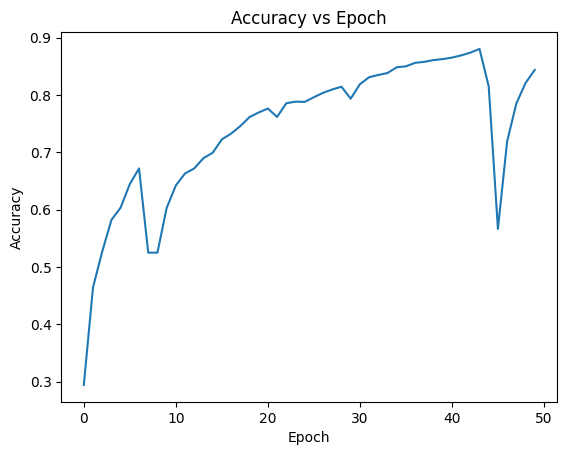

In [72]:
# Plot the accuracy vs epoch
plt.plot(history.history['sparse_categorical_accuracy'])
plt.title('Accuracy vs Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

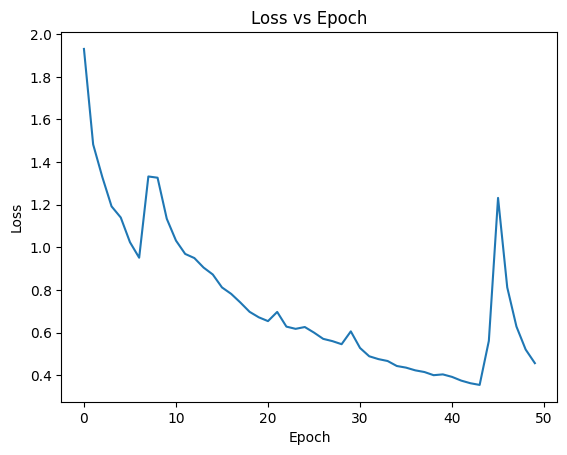

In [73]:
# Plot the Loss vs epoch
plt.plot(history.history['loss'])
plt.title('Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [74]:
# Calculating Accuracy of the Model on Test Data Set
evaluation = classifier.evaluate(x_test, y_test)
accuracy = evaluation[1]
loss = evaluation[0]
print('\n\n')
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test loss: {round(loss,2)}")

313/313 [==============================] - 4s 10ms/step - loss: 0.9079 - sparse_categorical_accuracy: 0.7631



Test accuracy: 76.31%
Test loss: 0.91


<i><b><h3> Train the Classifier with the pretrained Encoder</h3></b></i>


SupervisedContrastiveLoss function helps training the model is trained to maximize the similarity between pairs of images that belong to the same class, while also minimizing the similarity between pairs of images that belong to different classes.
<br><br>
It encourages the model to pull similar images closer together and push dissimilar images farther apart in the embedding space.


In [75]:
# Loss function used by encoder to minimize Supervised Contrastive Loss
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super().__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)


def add_projection_head(encoder):
    # Define the encoder network
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    outputs = layers.Dense(projection_units, activation="relu")(features)
    model = keras.Model(
        inputs=inputs, outputs=outputs, name="cifar-encoder_with_projection-head"
    )
    return model

<b><h5>Pretrain the Encoder </h5></b>

In [76]:
# Creating Encoder Instance
encoder = create_encoder()

encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)

encoder_with_projection_head.summary()

# Training the Encoder
history = encoder_with_projection_head.fit(
    x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs
)

Model: "cifar-encoder_with_projection-head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 cifar10-encoder (Functional  (None, 2048)             23564807  
 )                                                               
                                                                 
 dense_14 (Dense)            (None, 128)               262272    
                                                                 
Total params: 23,827,079
Trainable params: 23,781,632
Non-trainable params: 45,447
_________________________________________________________________
Epoch 1/50
189/189 [==============================] - 59s 126ms/step - loss: 5.3451
Epoch 2/50
189/189 [==============================] - 24s 128ms/step - loss: 5.1336
Epoch 3/50
189/189 [=========================

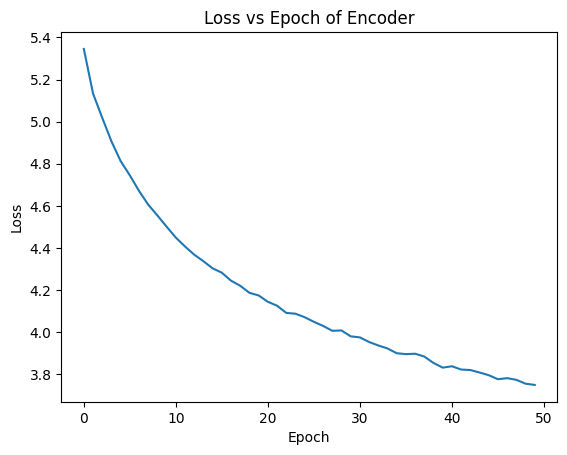

In [77]:
# Plot the Loss vs epoch of Encoder
plt.plot(history.history['loss'])
plt.title('Loss vs Epoch of Encoder')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

<b><h5> Train the Classifier with pre-trained Encoder </h5></b>

In [78]:
# Creating Classifier Instance with pre-trained Encoder
classifier = create_classifier(encoder, trainable=False)

# Training the Classifier on Training Dataset
history = classifier.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs)

# Saving Trained Model to Dricve so that we need not to train model each time it needs to used
classifier.save("/content/drive/MyDrive/SupContrast_Model/supcontrastive")


Epoch 1/50
189/189 [==============================] - 11s 37ms/step - loss: 0.3692 - sparse_categorical_accuracy: 0.8986
Epoch 2/50
189/189 [==============================] - 7s 35ms/step - loss: 0.3153 - sparse_categorical_accuracy: 0.9063
Epoch 3/50
189/189 [==============================] - 7s 35ms/step - loss: 0.3031 - sparse_categorical_accuracy: 0.9078
Epoch 4/50
189/189 [==============================] - 7s 35ms/step - loss: 0.3006 - sparse_categorical_accuracy: 0.9069
Epoch 5/50
189/189 [==============================] - 7s 35ms/step - loss: 0.2955 - sparse_categorical_accuracy: 0.9076
Epoch 6/50
189/189 [==============================] - 7s 36ms/step - loss: 0.2958 - sparse_categorical_accuracy: 0.9074
Epoch 7/50
189/189 [==============================] - 7s 35ms/step - loss: 0.2972 - sparse_categorical_accuracy: 0.9078
Epoch 8/50
189/189 [==============================] - 7s 35ms/step - loss: 0.2941 - sparse_categorical_accuracy: 0.9076
Epoch 9/50
189/189 [===================

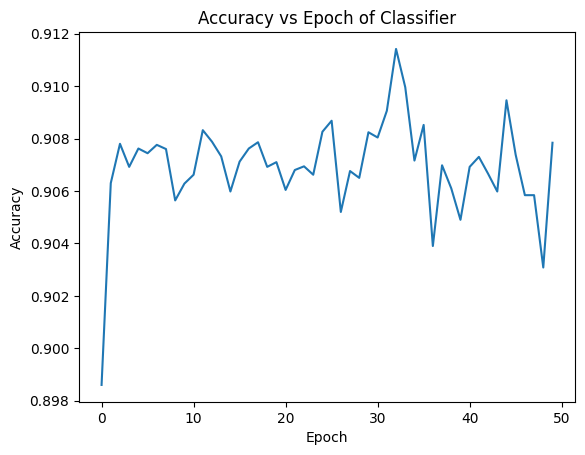

In [79]:
# Plot the accuracy vs epoch
plt.plot(history.history['sparse_categorical_accuracy'])
plt.title('Accuracy vs Epoch of Classifier')
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')
plt.show()

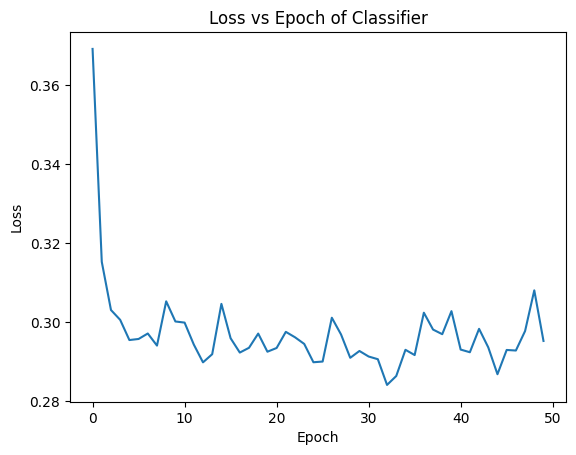

In [80]:
# Plot the accuracy vs epoch
plt.plot(history.history['loss'])
plt.title('Loss vs Epoch of Classifier')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [81]:
# Computing the Classifier Accuracy on Test Data Set
evaluation = classifier.evaluate(x_test, y_test)
accuracy = evaluation[1]
loss = evaluation[0]
print('\n\n')
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test loss: {round(loss,2)}")


313/313 [==============================] - 5s 11ms/step - loss: 0.7101 - sparse_categorical_accuracy: 0.8178



Test accuracy: 81.78%
Test loss: 0.71


<b><h3> Testing on Random Image </h3></b>

<i>Function which takes image as Input and predicts the class for the Image</i>

In [86]:
def predectImageClass(img):
  # Changing dimension of random image to the required dimension for Model
  image_resized = tf.expand_dims(tf.image.resize(img, (32,32,)), axis=0)

  # Predicting the Classifier Output
  predictions = classifier.predict([image_resized]).flatten() # Flatten the label arrays

  # Softmax converts a vector of values to a probability distribution
  predictions = tf.nn.softmax(predictions)

  # Class ID
  class_id = tf.argmax(predictions).numpy()

  # Printing the Image
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

  # Printing the Image Class
  print("\nThe predicted output : ", class_id)

Some Sample Images for Testing Purpose

1/1 [==============================] - 0s 54ms/step


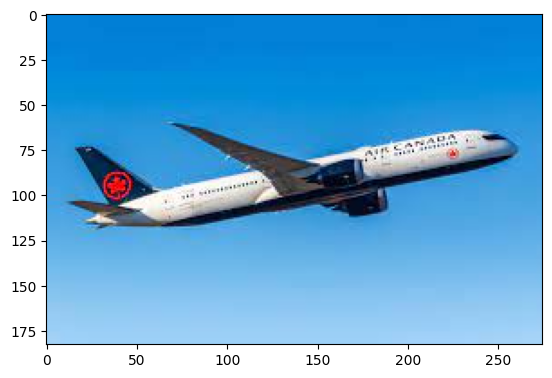


The predicted output :  0
1/1 [==============================] - 0s 35ms/step


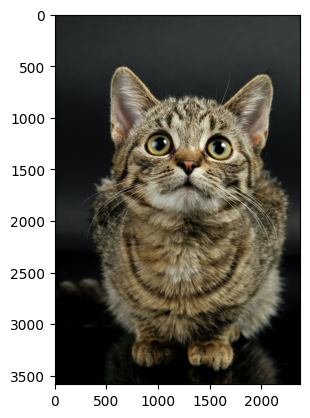


The predicted output :  8
1/1 [==============================] - 0s 24ms/step


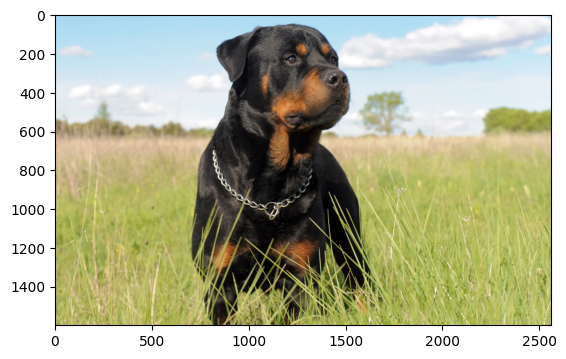


The predicted output :  3
1/1 [==============================] - 0s 40ms/step


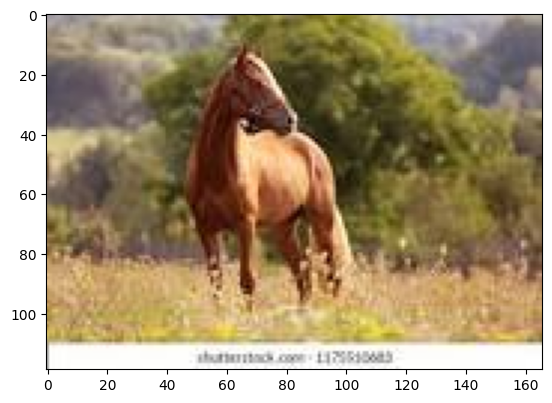


The predicted output :  1
1/1 [==============================] - 0s 25ms/step


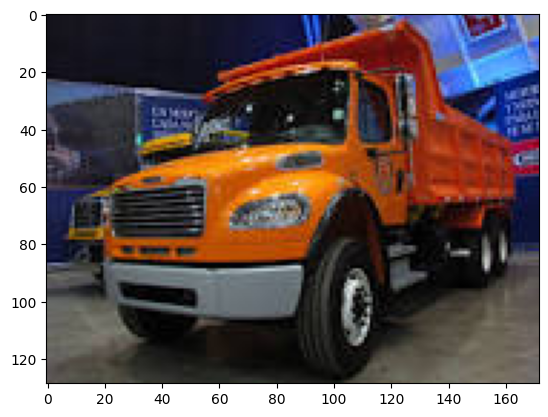


The predicted output :  1


In [88]:
image1 = cv2.imread(f"/content/drive/MyDrive/SupContrast_Model/download1.jpg")
predectImageClass(image1)

image2 = cv2.imread(f"/content/drive/MyDrive/SupContrast_Model/download2.jpg")
predectImageClass(image2)

image3 = cv2.imread(f"/content/drive/MyDrive/SupContrast_Model/download3.jpg")
predectImageClass(image3)

image4 = cv2.imread(f"/content/drive/MyDrive/SupContrast_Model/download4.jpg")
predectImageClass(image4)

image5 = cv2.imread(f"/content/drive/MyDrive/SupContrast_Model/download5.jpg")
predectImageClass(image5)